# <font color = 'indianred'>**HW2_Part_C - 10 Points** </font>
- **You have to submit only one file for this part of the HW**
  >(1) ipynb (colab notebook) and<br>

- **File should be named as follows**:
>FirstName_LastName_HW_2_part_C<br>

**For the HW**,
- enter your code into the cells that contain the placeholder **# CODE.**
- Answer question in marksdown cell with **Your response here**

# **HW2 Part C: Multi-label Classification with Neural Networks**

**Objective**: Learn how to solve a Multi-label classification problem using neural network in PyTorch by modifying a binary classification approach.

**Context**: You will modify an existing binary classification notebook to work with multi-label classification using the emotions dataset. This dataset contains music audio features and their associated emotions. Unlike binary or multi-class classification where each sample belongs to exactly one class, in multi-label classification, each sample can belong to multiple classes simultaneously. For example, a song can evoke multiple emotions like being both "happy-pleased" and "relaxing-calm".

The emotions dataset has 6 emotion labels:
- amazed-surprised
- happy-pleased  
- relaxing-calm
- quiet-still
- sad-lonely
- angry-aggressive

**Key Learning Goals**:
- Understand the differences between binary, multi-class, and multi-label classification
- Learn to use HammingDistance as an evaluation metric instead of accuracy
- Implement appropriate loss for multi-label problems
- Modify dataset classes and training loops for multi-label targets
- Create appropriate visualizations for multi-label results

**Tasks Overview**:
You will need to implement code in sections marked with `## code` to:
1. Load and process ARFF format data
2. Modify dataset class for multi-label targets  
3. Update loss functions and metrics for multi-label classification
4. Modify training and evaluation functions
5. Create multi-label specific visualizations

**Plan**:
1. Set Environment: Load and understand the libraries needed.
2. Load Data: Load emotions ARFF data and explore it.
3. Split Data: Use the provided train/test split
4. Create Datasets for multi-label targets
5. Functions to train & evaluate multi-label models using HammingDistance
6. Train & Evaluate Multi-label Model
> 6.1. Define Hyperparameters <br>
> 6.2. Define Training Configurations <br>
> 6.3. Model Training & Evaluation <br>
7. Model Testing with multi-label metrics
8. Inference (Predictions) <br>

# <Font color = 'indianred'>**1. Set Environment**

In [ ]:
!pip install uv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 114.1 MB/s eta 0:00:00


In [ ]:
!uv pip install torchmetrics

Using Python 3.12.11 environment at: /usr
Resolved 29 packages in 157ms
Prepared 2 packages in 75ms
Installed 2 packages in 6ms
 + lightning-utilities==0.15.2
 + torchmetrics==1.8.2


In [ ]:
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix

# Data handling and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
from scipy.io import arff

# file manipulation
from google.colab import drive
from pathlib import Path

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Multi-label metrics
from torchmetrics import HammingDistance


<Font color = 'indianred'>**Note**: **Remember to update the `base_folder`path, `data_folder` and `model_folder`in the next cells to point to the location where you yoiu want to store fata and model in your Google Drive.**

In [ ]:
# If running on Google Colab, use Google Drive as storage
if 'google.colab' in str(get_ipython()):
    from google.colab import drive  # Import Google Drive mounting utility
    drive.mount('/content/drive')  # Mount Google Drive

    # Set base folder path for storing data on Google Drive
    base_folder= Path('/content/drive/MyDrive/data')
    project_folder = Path('/content/drive/MyDrive/teaching_fall_2025/LLM_Fall_2025/')
# If running locally, specify a different path
else:
    # Set base folder path for storing data on local machine
    base_folder= Path('/home/harpreet/Insync/google_drive_shaannoor/data')
    project_folder = Path('/home/harpreet/Insync/google_drive_shaannoor/teaching_fall_2025/LLM_Fall_2025/')

Mounted at /content/drive


In [ ]:
# Students can set the data_folder and model_folder paths based on their base_folder setup.
data_folder = base_folder/'datasets/Mulan_emotions'
model_folder = project_folder/'0_saved_models/HW2_Part_C'
model_folder.mkdir(exist_ok=True, parents = True)
data_folder.mkdir(exist_ok=True, parents = True)

# <Font color = 'indianred'>**2. Load Data**

We will use the emotions dataset for multi-label classification. This dataset contains audio features extracted from music tracks and their associated emotions.

**Dataset Description**

The emotions dataset contains:
- **72 audio features** - These are numerical features extracted from music audio (MFCC, spectral features, etc.)
- **6 emotion labels** - Binary labels (0/1) indicating presence/absence of each emotion:
  - amazed-surprised
  - happy-pleased  
  - relaxing-calm
  - quiet-still
  - sad-lonely
  - angry-aggressive

**Multi-label Nature**\
Unlike traditional classification where each sample belongs to exactly one class, in multi-label classification each sample can belong to multiple classes simultaneously. For example, a song might be both "relaxing-calm" and "happy-pleased".

**Target variables**\
In multi-label classification, we have multiple binary target variables - one for each label. Each target can be 0 (emotion not present) or 1 (emotion present).



In [ ]:
def load_arff_data(file_path):
    """
    Load ARFF file and return features and labels
    """
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)

    # Convert bytes to string for any string columns
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.decode('utf-8')

    # Get emotion labels (last 6 columns)
    emotion_labels = ['amazed-suprised', 'happy-pleased', 'relaxing-calm',
                     'quiet-still', 'sad-lonely', 'angry-aggresive']

    # Features are all columns except the emotion labels
    feature_cols = [col for col in df.columns if col not in emotion_labels]

    X = df[feature_cols].values.astype(np.float32)
    y = df[emotion_labels].values.astype(np.float32)

    return X, y, feature_cols, emotion_labels

# Load training data
X_train, y_train, feature_names, emotion_labels = load_arff_data(data_folder/'emotions-train.arff')

# Load test data
X_test, y_test, _, _ = load_arff_data(data_folder/'emotions-test.arff')

print("Training data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)
print("Number of features:", len(feature_names))
print("Emotion labels:", emotion_labels)

Training data shape: (391, 72) (391, 6)
Test data shape: (202, 72) (202, 6)
Number of features: 72
Emotion labels: ['amazed-suprised', 'happy-pleased', 'relaxing-calm', 'quiet-still', 'sad-lonely', 'angry-aggresive']


In [ ]:
# Explore label distribution
print("Label distribution (training set):")
for i, label in enumerate(emotion_labels):
    count = np.sum(y_train[:, i])
    percentage = count / len(y_train) * 100
    print(f"{label}: {count}/{len(y_train)} ({percentage:.1f}%)")

print(f"\nAverage labels per sample: {np.mean(np.sum(y_train, axis=1)):.2f}")
print(f"Max labels per sample: {np.max(np.sum(y_train, axis=1))}")
print(f"Min labels per sample: {np.min(np.sum(y_train, axis=1))}")

# Show samples with different numbers of labels
label_counts = np.sum(y_train, axis=1)
print(f"\nSamples with 0 labels: {np.sum(label_counts == 0)}")
print(f"Samples with 1 label: {np.sum(label_counts == 1)}")
print(f"Samples with 2 labels: {np.sum(label_counts == 2)}")
print(f"Samples with 3+ labels: {np.sum(label_counts >= 3)}")

Label distribution (training set):
amazed-suprised: 119.0/391 (30.4%)
happy-pleased: 107.0/391 (27.4%)
relaxing-calm: 168.0/391 (43.0%)
quiet-still: 89.0/391 (22.8%)
sad-lonely: 95.0/391 (24.3%)
angry-aggresive: 131.0/391 (33.5%)

Average labels per sample: 1.81
Max labels per sample: 3.0
Min labels per sample: 1.0

Samples with 0 labels: 0
Samples with 1 label: 131
Samples with 2 labels: 202
Samples with 3+ labels: 58


In [ ]:
# Show first few samples
print("First 5 training samples (features):")
print("Feature values shape:", X_train[:5].shape)
print("Features (first 10):", X_train[0, :10])

print("\nFirst 5 training samples (labels):")
for i in range(5):
    active_labels = [emotion_labels[j] for j in range(len(emotion_labels)) if y_train[i, j] == 1]
    print(f"Sample {i}: {active_labels if active_labels else 'No labels'}")

First 5 training samples (features):
Feature values shape: (5, 72)
Features (first 10): [ 3.474100e-02  8.966500e-02  9.122500e-02 -7.330242e+01  6.215179e+00
  6.150740e-01  2.037160e+00  8.040650e-01  1.301409e+00  5.585760e-01]

First 5 training samples (labels):
Sample 0: ['happy-pleased', 'relaxing-calm']
Sample 1: ['amazed-suprised', 'angry-aggresive']
Sample 2: ['happy-pleased', 'angry-aggresive']
Sample 3: ['relaxing-calm']
Sample 4: ['quiet-still']


In [ ]:
print("Training features shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training features shape: (391, 72)
Training labels shape: (391, 6)
Test features shape: (202, 72)
Test labels shape: (202, 6)


In [ ]:
# Display shapes
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of emotion labels: {y_train.shape[1]}")

Number of training samples: 391
Number of test samples: 202
Number of features: 72
Number of emotion labels: 6


In [ ]:
print("Data types:")
print(f"X_train type: {type(X_train)}, dtype: {X_train.dtype}")
print(f"y_train type: {type(y_train)}, dtype: {y_train.dtype}")
print(f"X_test type: {type(X_test)}, dtype: {X_test.dtype}")
print(f"y_test type: {type(y_test)}, dtype: {y_test.dtype}")

Data types:
X_train type: <class 'numpy.ndarray'>, dtype: float32
y_train type: <class 'numpy.ndarray'>, dtype: float32
X_test type: <class 'numpy.ndarray'>, dtype: float32
y_test type: <class 'numpy.ndarray'>, dtype: float32


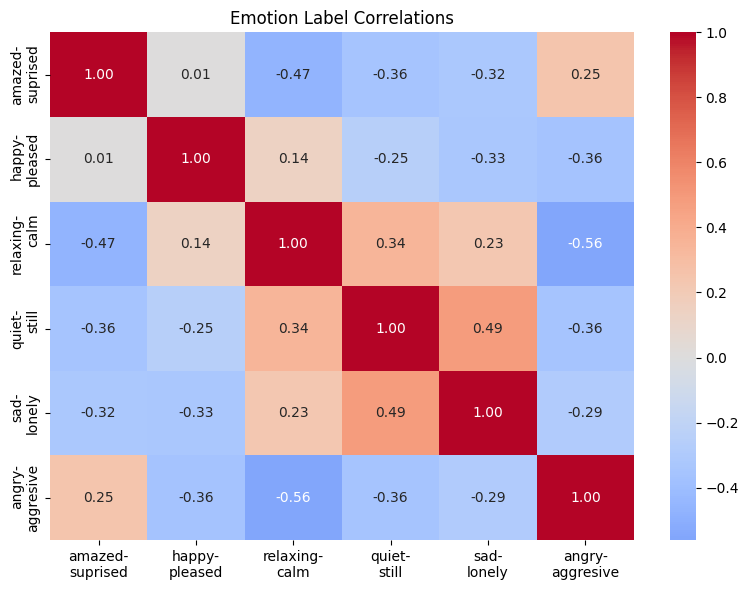

In [ ]:
# Visualize label correlations
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
# Calculate correlation matrix between emotion labels
label_corr = np.corrcoef(y_train.T)
sns.heatmap(label_corr,
            xticklabels=[label.replace('-', '-\n') for label in emotion_labels],
            yticklabels=[label.replace('-', '-\n') for label in emotion_labels],
            annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Emotion Label Correlations')
plt.tight_layout()
plt.show()

# <Font color = 'indianred'>**3. Split Data**

The emotions dataset comes with pre-defined train and test splits. We'll create a validation set by splitting the training data.

In [ ]:
# Split training data to create validation set (80% train, 20% validation)
# For multilabel stratification, we'll use iterative stratification from scikit-multilearn
# For simplicity, we'll use random split here
from sklearn.model_selection import train_test_split

X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Update the variables
X_train = X_train_new
y_train = y_train_new

# Print the shapes of the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Show label distribution in each split
print("\nLabel distribution across splits:")
for i, label in enumerate(emotion_labels):
    train_pct = np.mean(y_train[:, i]) * 100
    val_pct = np.mean(y_val[:, i]) * 100
    test_pct = np.mean(y_test[:, i]) * 100
    print(f"{label}: Train {train_pct:.1f}%, Val {val_pct:.1f}%, Test {test_pct:.1f}%")

Training set shape: (312, 72) (312, 6)
Validation set shape: (79, 72) (79, 6)
Test set shape: (202, 72) (202, 6)

Label distribution across splits:
amazed-suprised: Train 31.7%, Val 25.3%, Test 26.7%
happy-pleased: Train 26.6%, Val 30.4%, Test 29.2%
relaxing-calm: Train 40.4%, Val 53.2%, Test 47.5%
quiet-still: Train 21.5%, Val 27.8%, Test 29.2%
sad-lonely: Train 23.1%, Val 29.1%, Test 36.1%
angry-aggresive: Train 33.7%, Val 32.9%, Test 28.7%


**Note on splitting**: For multi-label classification, ideally we would use stratified sampling that maintains the label distribution across splits. For simplicity here, we use random splitting, but in practice, iterative stratification (from scikit-multilearn) is recommended for multi-label data.

# <Font color = 'indianred'>**4. Create Dataset for Multi-label Classification**


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for multi-label classification
    """
    def __init__(self, X, y):
        # Storing feature data
        self.X = X
        # Storing the multi-label targets
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Retrieve features and corresponding multi-labels from the dataset using the index
        inputs = self.X[idx]
        labels = self.y[idx]

        # Convert to tensors
        inputs = torch.tensor(inputs, dtype=torch.float32)
        # For multi-label classification, we use float32 instead of long
        # This is because each label is a probability/binary value (0 or 1)
        labels = # TODO: Complete this line

        # Return as tuple
        sample = (inputs, labels)

        return sample

In [ ]:
# Create TensorDatasets for each set
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_dataset, val_dataset, test_dataset

(<__main__.CustomDataset at 0x7c4caefca1e0>,
 <__main__.CustomDataset at 0x7c4cae608950>)

In [ ]:
train_dataset[0]

(tensor([ 2.9371e-02,  1.0822e-01,  7.5800e-02, -8.0774e+01,  1.0889e+01,
          5.3893e-01,  1.5216e+00,  1.1967e+00,  9.3902e-01,  5.1952e-01,
          6.7029e-01,  6.9100e-01,  4.5928e-01,  2.8731e-01,  4.5687e-01,
          4.0266e-01,  1.0834e-02,  8.0360e-02,  3.4776e-02,  3.7508e+00,
          9.6126e-01,  7.3358e-01,  5.2123e-01,  4.3591e-01,  3.9820e-01,
          3.8736e-01,  4.1519e-01,  4.0425e-01,  3.7670e-01,  3.9545e-01,
          3.7789e-01,  3.4162e-01,  1.4399e-02,  1.8027e-01,  7.8070e-03,
          5.1080e+00,  1.8800e+00,  1.0665e+00,  3.9243e-01,  5.3177e-01,
          3.1992e-01,  2.4815e-01,  3.7886e-01,  3.4683e-01,  2.4146e-01,
          2.6310e-01,  3.9240e-01,  3.4528e-01,  2.8195e-02,  1.4679e-01,
          2.9572e-02,  4.7687e+00,  5.2786e-01,  2.9698e-01,  1.4299e-01,
          1.5105e-01,  1.1864e-01,  9.0607e-02,  1.1609e-01,  1.2084e-01,
          9.8587e-02,  1.0846e-01,  1.2159e-01,  9.0832e-02,  8.3980e-03,
          8.1000e+01,  8.9430e-03,  1.

# <Font color = 'indianred'>**5. Functions to train & evaluate Multi-label Models**

The model training functions are adapted for multi-label classification. Instead of accuracy, we use HammingDistance as our metric. HammingDistance measures the fraction of labels that are incorrectly predicted (both false positives and false negatives). A lower HammingDistance indicates better performance.

For multi-label classification, we also use BCEWithLogitsLoss (Binary Cross Entropy with Logits) instead of CrossEntropyLoss, as each label is treated as an independent binary classification problem.

## <Font color = 'indianred'>*`step()` function*

In [ ]:
## code
# TODO: Modify the step function for multi-label classification
# DIFFERENCE FROM BINARY/MULTICLASS:
#   - Binary/Multiclass: Use torch.argmax(outputs, 1) to get single predicted class
#   - Multilabel: Use torch.sigmoid(outputs) > 0.5 to get multiple binary predictions
# DIFFERENCE IN METRICS:
#   - Binary/Multiclass: Calculate accuracy as (predicted == targets).sum()
#   - Multilabel: Calculate Hamming Distance as mean of incorrect label predictions
# WHY: In multilabel, each label is independent, so we need sigmoid + threshold for each label
# HINT: Hamming Distance = fraction of labels that are incorrectly predicted (both false positives and false negatives)

def step(inputs, targets, model, device, loss_function=None, optimizer=None, hamming_dist=None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets in multi-label setting.
    """
    # Move the model and data to the device
    model = model.to(device)
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions (logits)
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Calculate Hamming Distance
    # YOUR CODE HERE: Convert logits to binary predictions for multi-label classification
    # HINT: Apply sigmoid to get probabilities, then threshold at 0.5
    predicted = # TODO: Complete this line
    predicted = predicted.float()

    # Calculate Hamming Distance
    if hamming_dist:
        hamming_distance = hamming_dist(predicted.cpu(), targets.cpu()).item()
    else:
        hamming_distance = torch.mean((predicted != targets).float()).item()

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        # Step : Zero Gradients - Clear previous gradient information to prevent accumulation
        # Code HERE

        # Step : Calculate Gradients - Backpropagate the error to compute gradients for each parameter
        # Code HERE

        # Step : Update Model Parameters - Adjust weights based on computed gradients
        # Code HERE


    if loss_function:
        return loss, outputs, hamming_distance
    else:
        return None, outputs, hamming_distance



* explain step

## <Font color = 'indianred'>*`train_epoch()` function*

In [ ]:
def train_epoch(train_loader, model, device, loss_function, optimizer, hamming_dist=None):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to calculate loss.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.
    - hamming_dist (HammingDistance, optional): HammingDistance metric instance.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_hamming (float): Average training Hamming distance for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and Hamming distance
    running_train_loss = 0.0
    running_train_hamming = 0.0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, _, hamming_distance = step(inputs, targets, model, device, loss_function, optimizer, hamming_dist)

        # Update running loss and Hamming distance
        running_train_loss += loss.item()
        running_train_hamming += hamming_distance

    # Compute average loss and Hamming distance for the entire training set
    train_loss = running_train_loss / len(train_loader)
    train_hamming = running_train_hamming / len(train_loader)

    return train_loss, train_hamming


## <Font color = 'indianred'>*`val_epoch()` function*

In [ ]:
def val_epoch(valid_loader, model, device, loss_function, hamming_dist=None):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to calculate loss.
    - hamming_dist (HammingDistance, optional): HammingDistance metric instance.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_hamming (float): Average validation Hamming distance for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and Hamming distance
    running_val_loss = 0.0
    running_val_hamming = 0.0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Perform a forward pass to get loss and Hamming distance
            loss, _, hamming_distance = step(inputs, targets, model, device, loss_function, optimizer=None, hamming_dist=hamming_dist)

            # Update running loss and Hamming distance
            running_val_loss += loss.item()
            running_val_hamming += hamming_distance

    # Compute average loss and Hamming distance for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    val_hamming = running_val_hamming / len(valid_loader)

    return val_loss, val_hamming


## <Font color = 'indianred'>*`train()` function*

In [ ]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, hamming_dist=None):
    """
    Trains and validates the model for multi-label classification, returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to calculate loss.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).
    - hamming_dist (HammingDistance, optional): HammingDistance metric instance.

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_hamming_history (list): History of training Hamming distance for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_hamming_history (list): History of validation Hamming distance for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_hamming_history = []
    valid_hamming_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_hamming = train_epoch(train_loader, model, device, loss_function, optimizer, hamming_dist)

        # Validate model on validation data and capture metrics
        valid_loss, valid_hamming = val_epoch(valid_loader, model, device, loss_function, hamming_dist)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_hamming_history.append(train_hamming)
        valid_loss_history.append(valid_loss)
        valid_hamming_history.append(valid_hamming)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Hamming Distance: {train_hamming:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Hamming Distance: {valid_hamming:.4f}")
        print()

    return train_loss_history, train_hamming_history, valid_loss_history, valid_hamming_history


# <Font color = 'indianred'>**6. Train & Evaluate Multi-label Model**

## <Font color = 'indianred'>*6.1 Hyperparameters*

In [ ]:
# Hyperparameters for Multi-label Classification
batch_size = 32
learning_rate = 0.001  # Lower learning rate for multi-label
number_inputs = 72    # Number of audio features
number_outputs = ## Code Here
number_hidden_1 = 128
number_hidden_2 = 64
epochs = 30

## <Font color = 'indianred'>*6.2 Training Configurations*

In [ ]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Create datasets
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# Create data loaders
# Hint : Keep in mind which datasets you wnat to shuffle and which you do not want to shuffle
train_loader = ## Code Here
val_loader = ## Code Here
test_loader = ## Code Here

# Define the loss function for multi-label classification
loss_function = ## Code here

# Initialize HammingDistance metric
hamming_dist = HammingDistance(task='multilabel', num_labels=number_outputs)

# Define the model for multi-label classification
hidden_1 = ## Code here
hidden_2 = ## Code Here
output_layer = ## Code Here
model = nn.Sequential(hidden_1, nn.ReLU(), hidden_2, nn.ReLU(), output_layer)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")
print(f"Model architecture:")
print(model)

Using device: cuda:0
Model architecture:
Sequential(
  (0): Linear(in_features=72, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=6, bias=True)
)


## <Font color = 'indianred'>*6.3 Model Training & Evaluation*

In [ ]:
# Call the train function to train & evaluate the multi-label model
train_losses, train_hamming, valid_losses, valid_hamming = train(
    train_loader, val_loader, model, optimizer, loss_function, epochs, device, hamming_dist)

Epoch 1/30
Train Loss: 0.6350 | Train Hamming Distance: 0.3203
Valid Loss: 0.6631 | Valid Hamming Distance: 0.3355

Epoch 2/30
Train Loss: 0.6080 | Train Hamming Distance: 0.3082
Valid Loss: 0.6190 | Valid Hamming Distance: 0.3081

Epoch 3/30
Train Loss: 0.5935 | Train Hamming Distance: 0.2950
Valid Loss: 0.6341 | Valid Hamming Distance: 0.3355

Epoch 4/30
Train Loss: 0.5919 | Train Hamming Distance: 0.2927
Valid Loss: 0.6267 | Valid Hamming Distance: 0.3336

Epoch 5/30
Train Loss: 0.5890 | Train Hamming Distance: 0.2918
Valid Loss: 0.6256 | Valid Hamming Distance: 0.3027

Epoch 6/30
Train Loss: 0.5887 | Train Hamming Distance: 0.2844
Valid Loss: 0.6369 | Valid Hamming Distance: 0.3318

Epoch 7/30
Train Loss: 0.5784 | Train Hamming Distance: 0.2885
Valid Loss: 0.6075 | Valid Hamming Distance: 0.3355

Epoch 8/30
Train Loss: 0.5851 | Train Hamming Distance: 0.2813
Valid Loss: 0.6411 | Valid Hamming Distance: 0.3266

Epoch 9/30
Train Loss: 0.5764 | Train Hamming Distance: 0.2806
Valid Los

**Plot losses**

In [ ]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None, metric_name="Hamming Distance"):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., Hamming Distance) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.
        metric_name (str): Name of the metric being plotted.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plotting training and validation losses
    ax1.plot(epochs, train_losses, label="Train", marker='o')  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        ax1.plot(epochs, val_losses, label="Validation", marker='s')  # Plot validation losses
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.set_title("Training and Validation Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        ax2.plot(epochs, train_metrics, label="Train", marker='o')  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            ax2.plot(epochs, val_metrics, label="Validation", marker='s')  # Plot validation metrics
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel(metric_name)
        ax2.set_title(f"Training and Validation {metric_name}")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


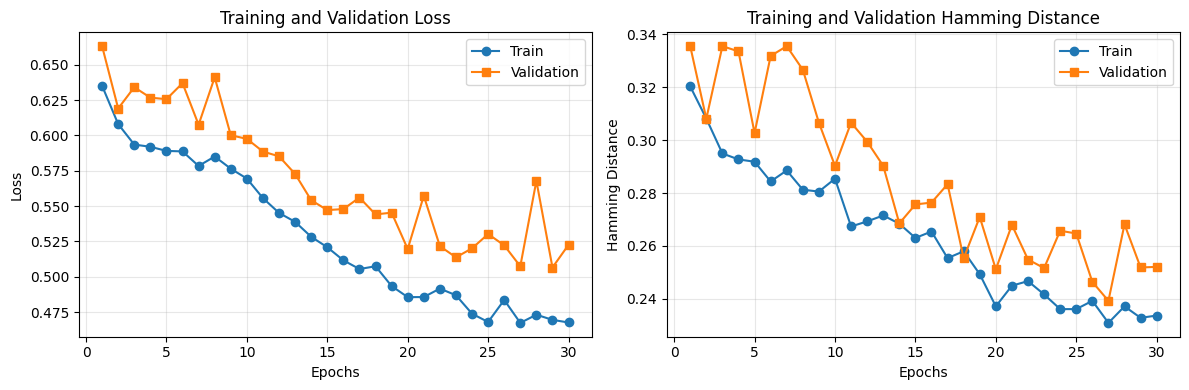

In [ ]:
plot_history(train_losses, train_hamming, valid_losses, valid_hamming, "Hamming Distance")

**Evaluate Multi-label Model on Validation Dataset**\

For multi-label classification, we need different evaluation metrics than traditional accuracy. We'll look at:

1. **Hamming Distance**: Fraction of labels that are incorrectly predicted (lower is better)
2. **Per-label Performance**: How well the model predicts each individual emotion
3. **Label Ranking**: How well the model ranks the labels for each sample

This comprehensive evaluation helps us understand which emotions the model predicts well and which need improvement.

In [ ]:
def get_multilabel_predictions(data_loader, model, device, hamming_dist=None, threshold=0.5):
    """
    Function to get predictions and metrics for multi-label classification
    Input: data iterator, model, device, hamming distance metric, threshold for binary predictions
    Output: predictions, true labels, Hamming distance, and detailed metrics
    """
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    all_predictions = torch.Tensor().to(device)
    all_probabilities = torch.Tensor().to(device)
    all_targets = torch.Tensor().to(device)
    running_hamming = 0.0

    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get outputs and Hamming distance
            _, outputs, hamming_distance = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None, hamming_dist=hamming_dist)

            # Get probabilities using sigmoid
            probabilities = torch.sigmoid(outputs)

            # Get binary predictions using threshold
            predicted = (probabilities > threshold).float()

            # Add the predicted labels, probabilities, and actual labels to their respective tensors
            all_predictions = torch.cat((all_predictions, predicted))
            all_probabilities = torch.cat((all_probabilities, probabilities))
            all_targets = torch.cat((all_targets, targets.to(device)))
            running_hamming += hamming_distance

    # Calculate overall Hamming distance
    avg_hamming_distance = running_hamming / len(data_loader)

    # Calculate per-label metrics
    per_label_metrics = {}
    for i, label in enumerate(emotion_labels):
        true_labels = all_targets[:, i]
        pred_labels = all_predictions[:, i]

        # Calculate precision, recall, F1 for each label
        tp = torch.sum((pred_labels == 1) & (true_labels == 1)).item()
        fp = torch.sum((pred_labels == 1) & (true_labels == 0)).item()
        fn = torch.sum((pred_labels == 0) & (true_labels == 1)).item()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        per_label_metrics[label] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': torch.sum(true_labels).item()
        }

    # Return predictions, probabilities, targets, metrics
    return all_predictions, all_probabilities, all_targets, avg_hamming_distance, per_label_metrics

In [ ]:
# Get predictions and detailed metrics for validation set
predictions_val, probabilities_val, targets_val, hamming_val, per_label_metrics_val = get_multilabel_predictions(
    val_loader, model, device, hamming_dist, threshold=0.5)

print(f"Validation Hamming Distance: {hamming_val:.4f}")
print("\nPer-label Performance on Validation Set:")
print("-" * 60)
for label, metrics in per_label_metrics_val.items():
    print(f"{label:20}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, "
          f"F1={metrics['f1']:.3f}, Support={metrics['support']}")

# Calculate and display some additional metrics
print(f"\nAverage F1 Score: {np.mean([m['f1'] for m in per_label_metrics_val.values()]):.3f}")
print(f"Average Precision: {np.mean([m['precision'] for m in per_label_metrics_val.values()]):.3f}")
print(f"Average Recall: {np.mean([m['recall'] for m in per_label_metrics_val.values()]):.3f}")

Validation Hamming Distance: 0.2521

Per-label Performance on Validation Set:
------------------------------------------------------------
amazed-suprised     : Precision=1.000, Recall=0.250, F1=0.400, Support=20.0
happy-pleased       : Precision=0.000, Recall=0.000, F1=0.000, Support=24.0
relaxing-calm       : Precision=0.774, Recall=0.571, F1=0.658, Support=42.0
quiet-still         : Precision=0.607, Recall=0.773, F1=0.680, Support=22.0
sad-lonely          : Precision=0.476, Recall=0.435, F1=0.455, Support=23.0
angry-aggresive     : Precision=0.875, Recall=0.538, F1=0.667, Support=26.0

Average F1 Score: 0.476
Average Precision: 0.622
Average Recall: 0.428


In [ ]:
# Create a function to plot per-label confusion matrices
def plot_multilabel_confusion_matrices(targets, predictions, emotion_labels):
    """
    Plot confusion matrices for each emotion label
    """
    n_labels = len(emotion_labels)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, label in enumerate(emotion_labels):
        # Get true and predicted labels for this emotion
        y_true = targets[:, i].cpu().numpy()
        y_pred = predictions[:, i].cpu().numpy()

        # Create confusion matrix
        cm = confusion_matrix(y_true, y_pred, normalize='true')

        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=['Not Present', 'Present'],
                    yticklabels=['Not Present', 'Present'],
                    ax=axes[i])
        axes[i].set_title(f'{label.replace("-", "-\n")}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()


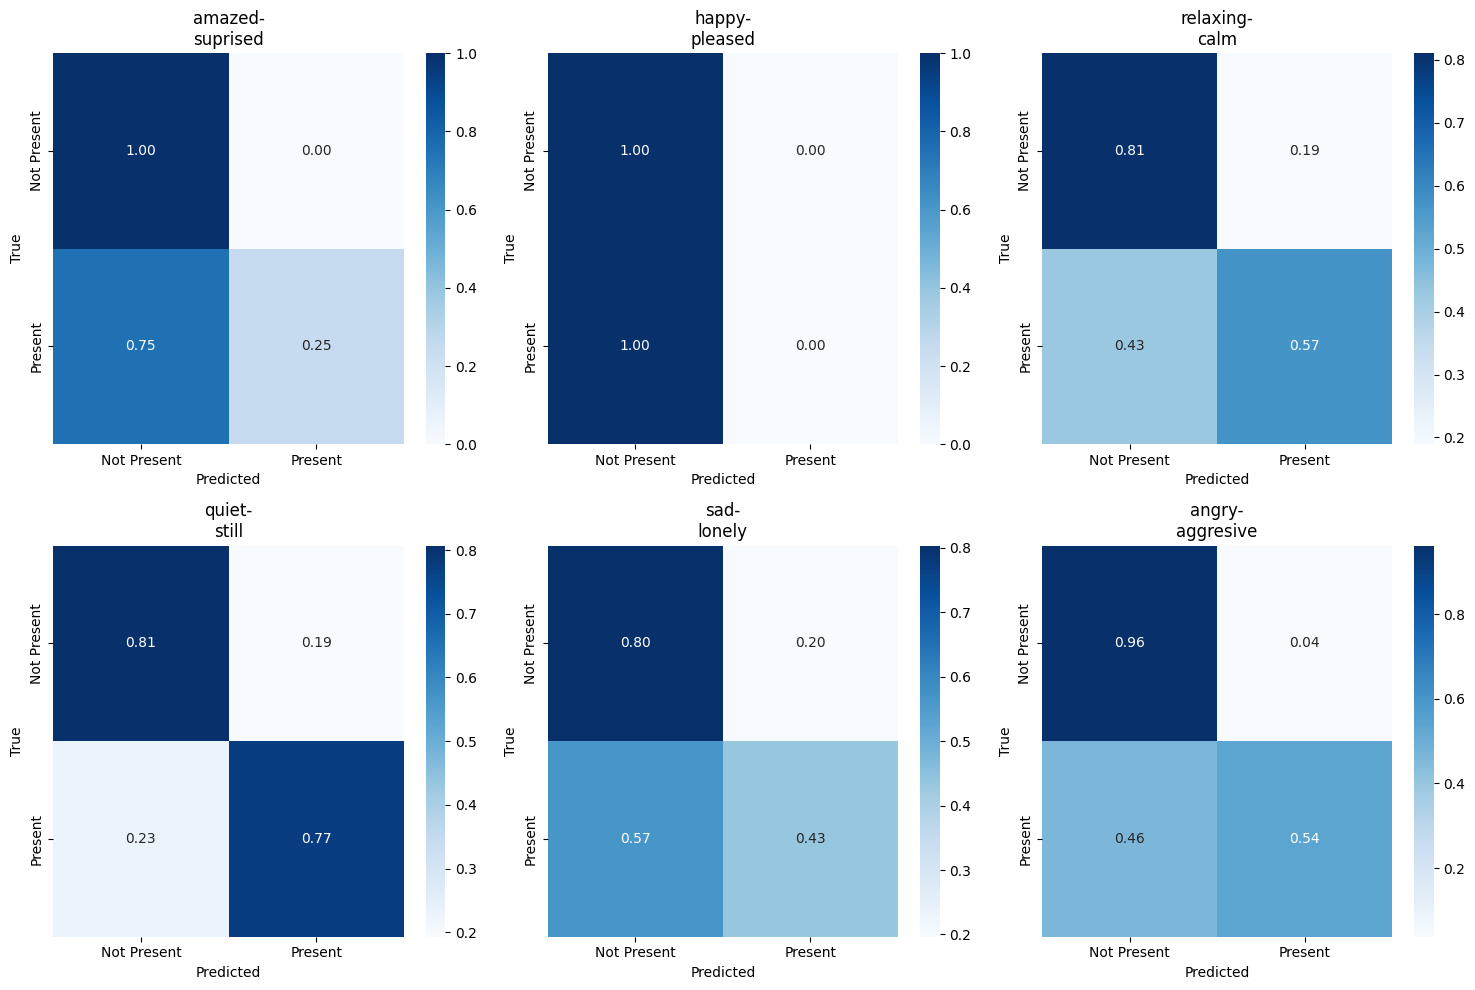

In [ ]:
# Plot confusion matrices for each emotion
plot_multilabel_confusion_matrices(targets_val, predictions_val, emotion_labels)

<Font color = 'indianred'>**What do you conclude from the above Graphs?**</font><br>
**Type Your Answer Here:**

**Model checkpointing**



In [ ]:
# file name for model to save
file_name = model_folder/'multilabel_emotions_model.pt'

In [ ]:
torch.save(## Code Here, file_name)
print(f"Model saved to {file_name}")

Model saved to /content/drive/MyDrive/data/models/multilabel_emotions_model.pt


# <Font color = 'indianred'>**7. Model Testing on Test Set**

Now that we have trained our multi-label emotion classification model, let's evaluate it on the test set to get an unbiased estimate of its performance.

In [ ]:
# Load the saved model for testing
# instantiate model
hidden_1 = ## Code Here
hidden_2 = ## Code Here
output_layer = ## Code Here
test_model = nn.Sequential(hidden_1, nn.ReLU(), hidden_2, nn.ReLU(), output_layer)

# Load the model's state dictionary from the checkpoint file
checkpoint = torch.load(file_name)

# Load the saved state dictionary into the model
test_model.load_state_dict(checkpoint)

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
# Evaluate model on test set
predictions_test, probabilities_test, targets_test, hamming_test, per_label_metrics_test = get_multilabel_predictions(
    test_loader, test_model, device, hamming_dist, threshold=0.5)

print(f"Test Hamming Distance: {hamming_test:.4f}")
print("\nPer-label Performance on Test Set:")
print("-" * 60)
for label, metrics in per_label_metrics_test.items():
    print(f"{label:20}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, "
          f"F1={metrics['f1']:.3f}, Support={metrics['support']}")

# Calculate and display some additional metrics
print(f"\nTest Set Results:")
print(f"Average F1 Score: {np.mean([m['f1'] for m in per_label_metrics_test.values()]):.3f}")
print(f"Average Precision: {np.mean([m['precision'] for m in per_label_metrics_test.values()]):.3f}")
print(f"Average Recall: {np.mean([m['recall'] for m in per_label_metrics_test.values()]):.3f}")

# Compare validation vs test performance
print(f"\nValidation vs Test Hamming Distance:")
print(f"Validation: {hamming_val:.4f}")
print(f"Test: {hamming_test:.4f}")
print(f"Difference: {abs(hamming_test - hamming_val):.4f}")

if abs(hamming_test - hamming_val) < 0.05:
    print("✓ Model generalizes well (small difference between validation and test)")
else:
    print("⚠ Large difference between validation and test - check for overfitting")


Test Hamming Distance: 0.2741

Per-label Performance on Test Set:
------------------------------------------------------------
amazed-suprised     : Precision=0.667, Recall=0.259, F1=0.373, Support=54.0
happy-pleased       : Precision=0.000, Recall=0.000, F1=0.000, Support=59.0
relaxing-calm       : Precision=0.635, Recall=0.562, F1=0.597, Support=96.0
quiet-still         : Precision=0.613, Recall=0.780, F1=0.687, Support=59.0
sad-lonely          : Precision=0.639, Recall=0.534, F1=0.582, Support=73.0
angry-aggresive     : Precision=0.660, Recall=0.534, F1=0.590, Support=58.0

Test Set Results:
Average F1 Score: 0.472
Average Precision: 0.536
Average Recall: 0.445

Validation vs Test Hamming Distance:
Validation: 0.2521
Test: 0.2741
Difference: 0.0220
✓ Model generalizes well (small difference between validation and test)


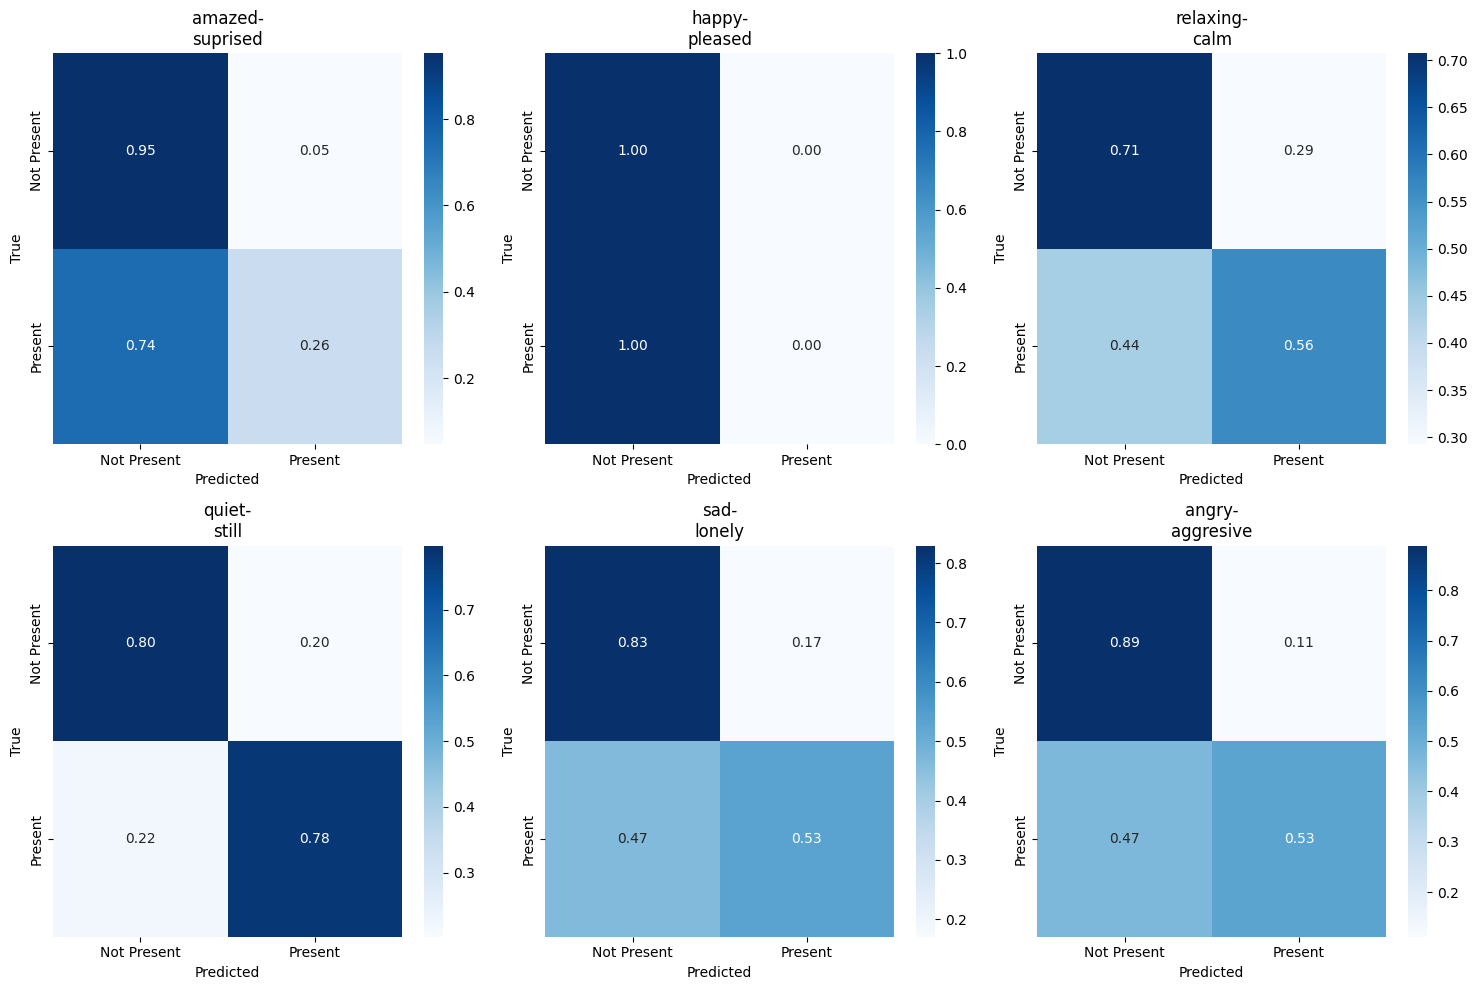

In [ ]:
# Plot test set confusion matrices
plot_multilabel_confusion_matrices(targets_test, predictions_test, emotion_labels)

# <Font color = 'indianred'>**8. Inference (Predictions)**

Let's test our model on a few sample inputs to see how it predicts emotions.

In [ ]:
# Test on a few samples from the test set
sample_X = torch.tensor(X_test[0:5]).float().to(device)
test_model.eval()

with torch.no_grad():
    logits = test_model(sample_X)
    probabilities = torch.sigmoid(logits)
    predictions = (probabilities > 0.5).float()

print("Sample Predictions:")
print("=" * 50)
for i in range(5):
    print(f"\nSample {i+1}:")
    print("Actual emotions:", [emotion_labels[j] for j in range(len(emotion_labels)) if y_test[i, j] == 1])
    print("Predicted emotions:", [emotion_labels[j] for j in range(len(emotion_labels)) if predictions[i, j] == 1])
    print("Probabilities:")
    for j, label in enumerate(emotion_labels):
        print(f"  {label:15}: {probabilities[i, j].item():.3f}")

print(f"\nLogits for first sample: {logits[0].cpu().numpy()}")
print(f"Probabilities for first sample: {probabilities[0].cpu().numpy()}")
print(f"Binary predictions for first sample: {predictions[0].cpu().numpy()}")

Sample Predictions:

Sample 1:
Actual emotions: ['relaxing-calm', 'quiet-still', 'sad-lonely']
Predicted emotions: ['relaxing-calm', 'quiet-still', 'sad-lonely']
Probabilities:
  amazed-suprised: 0.145
  happy-pleased  : 0.119
  relaxing-calm  : 0.570
  quiet-still    : 0.616
  sad-lonely     : 0.565
  angry-aggresive: 0.165

Sample 2:
Actual emotions: ['amazed-suprised', 'angry-aggresive']
Predicted emotions: ['angry-aggresive']
Probabilities:
  amazed-suprised: 0.398
  happy-pleased  : 0.159
  relaxing-calm  : 0.130
  quiet-still    : 0.012
  sad-lonely     : 0.096
  angry-aggresive: 0.635

Sample 3:
Actual emotions: ['sad-lonely']
Predicted emotions: []
Probabilities:
  amazed-suprised: 0.362
  happy-pleased  : 0.162
  relaxing-calm  : 0.238
  quiet-still    : 0.082
  sad-lonely     : 0.239
  angry-aggresive: 0.436

Sample 4:
Actual emotions: ['happy-pleased', 'relaxing-calm']
Predicted emotions: ['relaxing-calm', 'quiet-still']
Probabilities:
  amazed-suprised: 0.121
  happy-please

In [ ]:
# Summary of the multilabel classification approach
print("=" * 60)
print("MULTI-LABEL CLASSIFICATION SUMMARY")
print("=" * 60)
print(f"Dataset: Emotions dataset with {len(emotion_labels)} emotion labels")
print(f"Features: {number_inputs} audio features")
print(f"Model: {number_hidden_1}-{number_hidden_2} hidden layer neural network")
print(f"Loss function: BCEWithLogitsLoss (suitable for multi-label)")
print(f"Metric: Hamming Distance (fraction of incorrectly predicted labels)")
print(f"Training epochs: {epochs}")

print(f"\nFinal Results:")
print(f"Validation Hamming Distance: {hamming_val:.4f}")
print(f"Test Hamming Distance: {hamming_test:.4f}")
print(f"Average Test F1 Score: {np.mean([m['f1'] for m in per_label_metrics_test.values()]):.3f}")

print(f"\nKey Differences from Binary Classification:")
print("- Each sample can have multiple labels (0 to 6 emotions)")
print("- Used BCEWithLogitsLoss instead of CrossEntropyLoss")
print("- Used Hamming Distance instead of accuracy")
print("- Applied sigmoid + threshold for final predictions")
print("- Evaluated per-label precision, recall, and F1-scores")

MULTI-LABEL CLASSIFICATION SUMMARY
Dataset: Emotions dataset with 6 emotion labels
Features: 17 audio features
Model: 100-100 hidden layer neural network
Loss function: BCEWithLogitsLoss (suitable for multi-label)
Metric: Hamming Distance (fraction of incorrectly predicted labels)
Training epochs: 10

Final Results:
Validation Hamming Distance: 0.2521
Test Hamming Distance: 0.2741
Average Test F1 Score: 0.472

Key Differences from Binary Classification:
- Each sample can have multiple labels (0 to 6 emotions)
- Used BCEWithLogitsLoss instead of CrossEntropyLoss
- Used Hamming Distance instead of accuracy
- Applied sigmoid + threshold for final predictions
- Evaluated per-label precision, recall, and F1-scores
